# Notebook de Análisis y Mejora del Modelo de Estimación

**Descripción:** En esta sección se importan las librerías necesarias para el análisis, modelado y visualización de datos. También se carga el dataset que contiene las historias de usuario, sus descripciones en formato Gherkin, y las etiquetas de esfuerzo y tiempo.
Propósito: Configurar el entorno de trabajo con las herramientas necesarias y cargar los datos para su posterior procesamiento.

## Carga de Librerías y Datos

In [68]:
import pandas as pd
import numpy as np
import re
import spacy

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack 

# --- Modelado y Preprocesamiento ---
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

sns.set_theme(style="whitegrid")  # Configura el estilo visual de Seaborn para gráficos

# Lista de características numéricas que se generarán en la ingeniería de características
NUMERICAL_FEATURES = [
    'gherkin_steps', 'gherkin_length', 'num_scenarios', 'num_technical_terms',
    'num_conditions', 'num_entities', 'num_roles',
    'has_frontend', 'has_backend', 'has_security', 'has_payment', 'has_crud',
    'has_reporting', 'has_integration', 'has_notification', 'has_devops_mlops',
    'has_accessibility', 'has_mobile', 'has_testing', 'has_error_handling',
    'has_ui_interaction', 'has_database_query', 'tech_java', 'tech_node',
    'tech_python', 'tech_frontend_framework', 'tech_database', 'tech_infra_cloud'
]

# Carga del modelo de spaCy para procesamiento de texto en español
try:
    nlp = spacy.load('es_core_news_sm')
except OSError:
    print("Modelo 'es_core_news_sm' no encontrado. Por favor, ejecute: python -m spacy download es_core_news_sm")
    exit()

# Carga del dataset desde un archivo CSV
try:
    df = pd.read_csv('stories_dataset.csv')
    print("Dataset cargado exitosamente.")
    display(df.head())  # Muestra las primeras 5 filas del dataset
except FileNotFoundError:
    print("ERROR: No se encontró 'stories_dataset.csv'.")   

Dataset cargado exitosamente.


,id,title,gherkin,effort,time
0,1,Exportar reporte de ventas a PDF,Feature: Exportar reporte de ventas\nScenario:...,8,12
1,2,Carga de avatar de perfil a S3,Feature: Carga de avatar de perfil\nScenario: ...,13,20
2,3,Login de usuario con API externa,Feature: Autenticación de usuario\nScenario: U...,5,8
3,4,Implementar paginación en lista de productos,Feature: Lista de productos\nScenario: Usuario...,3,5
4,5,Procesar pago con tarjeta de crédito,Feature: Checkout\nScenario: Usuario realiza u...,21,35


- **NUMERICAL_FEATURES:** Define las características numéricas que se generarán en la ingeniería de características, incluyendo métricas derivadas del texto (como la longitud de Gherkin) y características binarias basadas en palabras clave.
- **Carga de spaCy:** Se carga el modelo es_core_news_sm para lematización de texto en español. Si no está instalado, se muestra un mensaje de error.
- **Carga de Datos:** El dataset se carga desde el archivo stories_dataset.csv. Se verifica la existencia del archivo y se muestran las primeras filas para inspección inicial.

Salida Esperada: Una vista previa del dataset con columnas como id, title, gherkin, effort, y time.

## Análisis Exploratorio de Datos (EDA)

**Descripción:** Esta sección realiza un análisis exploratorio para entender la distribución de las variables objetivo (effort y time), lo que ayuda a identificar posibles sesgos, outliers o patrones en los datos.
Propósito: Visualizar la distribución de las variables objetivo para evaluar si están equilibradas, presentan asimetrías o requieren transformaciones antes del modelado.

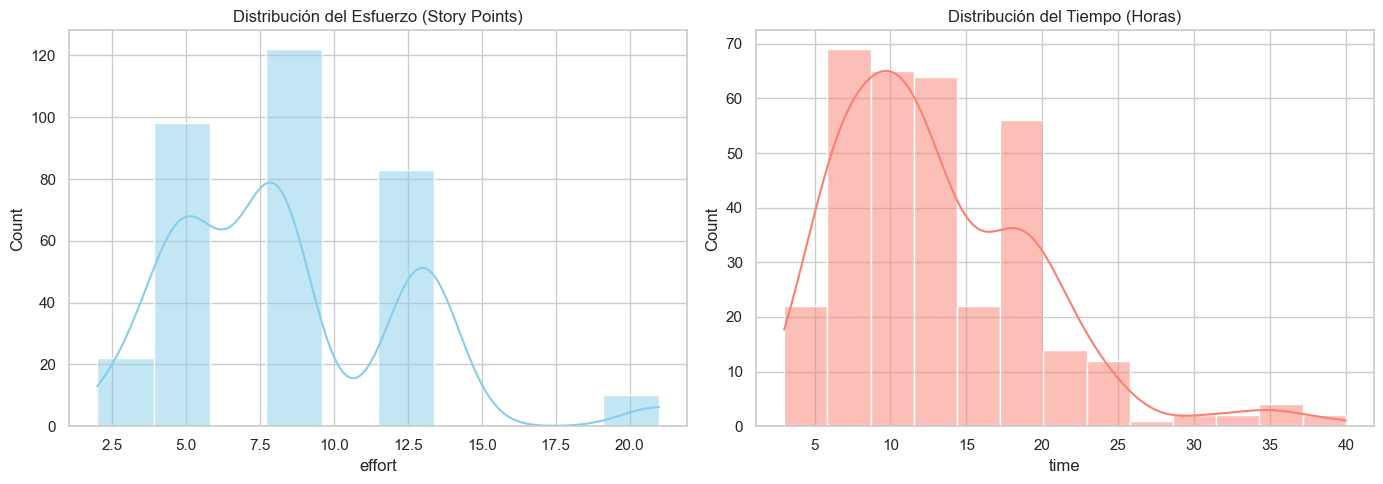

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['effort'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución del Esfuerzo (Story Points)')

sns.histplot(df['time'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribución del Tiempo (Horas)')

plt.tight_layout()
plt.show()

## Preparación de Datos y Feature Engineering

Aquí realizamos toda la preparación de datos, incluyendo la ingeniería de características que probamos anteriormente.

Esta sección realiza la limpieza de datos, genera nuevas características a partir del texto de las historias de usuario (título y Gherkin), y prepara los datos para el modelado.
Propósito: Transformar los datos crudos en un formato adecuado para el modelo, extrayendo características relevantes que capturen la complejidad de las tareas descritas.

In [70]:
def extract_features(df: pd.DataFrame) -> (pd.DataFrame, list):
    """
    Extrae características del DataFrame y devuelve el DataFrame modificado
    y la lista de nuevas características numéricas.
    """
    df_featured = df.copy()

    # --- Validación y Limpieza ---
    expected_cols = ['id', 'title', 'gherkin', 'effort', 'time']
    if not all(col in df_featured.columns for col in expected_cols):
        raise ValueError("Columnas esenciales faltantes.")

    df_featured['gherkin'] = df_featured['gherkin'].astype(str).fillna('')
    df_featured['title'] = df_featured['title'].astype(str).fillna('')
    df_featured['full_text'] = df_featured['title'] + " " + df_featured['gherkin']

    # --- Características Basadas en Categorías (Regex mejoradas con \b) ---
    keyword_categories = {
        'has_frontend': r'\b(?:frontend|UI|interfaz|CSS|React|Angular|Vue|diseño|vista|pantalla)\b',
        'has_backend': r'\b(?:backend|servidor|database|base de datos|bd|API|endpoint|SQL|servicios|microservicio|Java|NodeJS|NestJS|Python)\b',
        'has_security': r'\b(?:seguridad|security|JWT|OAuth|token|autenticación|contraseña|encriptar|CSRF|XSS)\b',
        'has_payment': r'\b(?:pago|payment|stripe|paypal|tarjeta de crédito|checkout|factura|compra)\b',
        'has_crud': r'\b(?:crear|añadir|guardar|editar|actualizar|modificar|eliminar|borrar|ver|listar|obtener)\b',
        'has_reporting': r'\b(?:reporte|dashboard|gráfico|exportar|CSV|PDF|Excel|analíticas|métricas)\b',
        'has_integration': r'\b(?:api externa|third-party|integración|webhook|sincronizar|CRM|ERP)\b',
        'has_notification': r'\b(?:notificación|email|correo|SMS|push|alerta|mensaje)\b',
        'has_devops_mlops': r'\b(?:CI/CD|pipeline|deploy|despliegue|Kubernetes|Docker|monitor|observabilidad|modelo|ML|IA|DevOps)\b',
        'has_accessibility': r'\b(?:accesibilidad|accessibility|WCAG|lector de pantalla|screen reader|ARIA)\b',
        'has_mobile': r'\b(?:móvil|app|push|biometría|offline|geolocalización|cámara|gesto)\b',
        'has_testing': r'\b(?:test|prueba|mock|verificar|validar|assertion|simula)\b',
        'has_error_handling': r'\b(?:error|excepción|exception|fallo|failure|validar|manejo de error)\b',
        'has_ui_interaction': r'\b(?:clic|seleccionar|navegar|click|select)\b',
        'has_database_query': r'\b(?:query|select|sql|database|base de datos|bd)\b'
    }
    for feature_name, pattern in keyword_categories.items():
        df_featured[feature_name] = df_featured['full_text'].str.contains(pattern, case=False, regex=True, na=False).astype(int)

    tech_stack_keywords = {
        'tech_java': r'\b(?:java|spring|maven|gradle|JPA|hibernate)\b',
        'tech_node': r'\b(?:node\.?js|nestjs|express|npm|yarn)\b',
        'tech_python': r'\b(?:python|django|flask|fastapi|pip)\b',
        'tech_frontend_framework': r'\b(?:react|angular|vue|svelte)\b',
        'tech_database': r'\b(?:sql|mysql|postgres|mongodb|redis|base de datos|database)\b',
        'tech_infra_cloud': r'\b(?:aws|azure|gcp|docker|kubernetes|terraform|S3)\b'
    }
    for tech_name, pattern in tech_stack_keywords.items():
        df_featured[tech_name] = df_featured['full_text'].str.contains(pattern, case=False, regex=True, na=False).astype(int)

    # --- Características Cuantitativas ---
    gherkin_keywords = [r'\bGiven\b', r'\bWhen\b', r'\bThen\b', r'\bAnd\b', r'\bDado\b', r'\bCuando\b', r'\bEntonces\b', r'\bY\b']
    df_featured['gherkin_steps'] = df_featured['gherkin'].apply(lambda x: sum(len(re.findall(word, x, re.IGNORECASE)) for word in gherkin_keywords))
    df_featured['gherkin_length'] = df_featured['gherkin'].str.len()
    df_featured['num_scenarios'] = df_featured['gherkin'].str.count(r'\b(Scenario|Escenario)\b', re.IGNORECASE)
    df_featured['num_conditions'] = df_featured['gherkin'].str.lower().str.count(r'\b(if|when|si)\b')

    # Lista de todas las características numéricas creadas
    numerical_features = list(keyword_categories.keys()) + \
                         list(tech_stack_keywords.keys()) + \
                         ['gherkin_steps', 'gherkin_length', 'num_scenarios', 'num_conditions']

    # --- Limpieza Final ---
    if (df_featured['effort'] < 0).any() or (df_featured['time'] < 0).any():
        raise ValueError("Valores negativos encontrados en 'effort' o 'time'")
    for col in numerical_features:
        df_featured[col] = pd.to_numeric(df_featured[col], errors='coerce').fillna(0).astype(float)

    return df_featured, numerical_features

## Función extract_features:

**Validación:** Verifica que el dataset contenga las columnas esperadas (id, title, gherkin, effort, time). Si falta alguna, lanza un error.

**Limpieza:** Convierte las columnas de texto a cadenas y rellena valores nulos con cadenas vacías. Combina title y gherkin en una nueva columna full_text.

**Características Categóricas:** Utiliza expresiones regulares con límites de palabra (\b) para identificar la presencia de palabras clave relacionadas con categorías como frontend, backend, seguridad, pagos, etc. Cada categoría genera una característica binaria (0 o 1).

**Características Tecnológicas:** Similar a las categóricas, identifica tecnologías específicas (Java, Node.js, Python, etc.) mediante regex.
Características Cuantitativas: Calcula métricas como el número de pasos en Gherkin (gherkin_steps), la longitud del texto Gherkin (gherkin_length), el número de escenarios (num_scenarios) y el número de condiciones (num_conditions).

**Limpieza Final:** Asegura que no haya valores negativos en effort o time y convierte las características numéricas a tipo float, rellenando valores nulos con 0.

In [71]:
def lemmatize_text(text):
    """
    Convierte un texto en una cadena de lemas.
    Es más eficiente que un simple stemmer para el español.
    """
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

## Función lemmatize_text:

Usa el modelo es_core_news_sm de spaCy para lematizar el texto, eliminando palabras vacías (stop words) y puntuación. La lematización reduce las palabras a su forma base (por ejemplo, "corriendo" → "correr"), lo que mejora la consistencia en el análisis de texto.
Devuelve una cadena de lemas separados por espacios, lista para ser procesada por TfidfVectorizer.

In [72]:
# Aplicar la extracción de características
df_featured, NUMERICAL_FEATURES = extract_features(df)

# Lematizar la columna de texto. En datasets grandes, esto puede tardar.
df_featured['full_text_lemmatized'] = df_featured['full_text'].apply(lemmatize_text)

# Definir las variables X e y para el modelo
X = df_featured
y = df_featured[['effort', 'time']]

Se aplica extract_features al dataset original para generar df_featured y la lista NUMERICAL_FEATURES.
Se lematiza la columna full_text para crear full_text_lemmatized.
Se definen las variables X (DataFrame con todas las columnas) y y (DataFrame con effort y time) para el modelado.


**Salida Esperada:** Un DataFrame df_featured con nuevas columnas de características derivadas y una columna full_text_lemmatized con el texto procesado. La lista NUMERICAL_FEATURES contiene los nombres de las características numéricas generadas.
Notas Técnicas:

La lematización puede ser computacionalmente costosa en datasets grandes. Si el tiempo de ejecución es un problema, considerar usar un stemmer más ligero (como SnowballStemmer de NLTK) o limitar el número de documentos procesados.
Las expresiones regulares usan \b para evitar coincidencias parciales (por ejemplo, "security" no coincidirá con "insecurity").

## Construcción y Optimización del Modelo

**Descripción:** Esta sección construye un pipeline de preprocesamiento y modelado, optimiza los hiperparámetros del modelo GradientBoostingRegressor utilizando GridSearchCV, y evalúa el rendimiento del modelo optimizado.

**Propósito:** Crear un modelo robusto que combine características de texto (procesadas con TF-IDF) y características numéricas (escaladas), optimizando su rendimiento mediante una búsqueda de hiperparámetros.

In [ ]:
# Preprocesador para el Modelo Base (solo texto)
preprocessor_base = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=500), 'full_text_lemmatized')
    ],
    remainder='drop'
)

# Preprocesador para el Modelo Mejorado (texto + features numéricas)
preprocessor_improved = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=500), 'full_text_lemmatized'),
        ('numeric', StandardScaler(), NUMERICAL_FEATURES)
    ],
    remainder='drop'
)

# --- 2. Crear un Pipeline para cada modelo ---

pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('model', MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)))
])

pipeline_improved = Pipeline(steps=[
    ('preprocessor', preprocessor_improved),
    ('model', MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)))
])


# --- 3. Configurar la búsqueda de hiperparámetros ---
# La misma cuadrícula de parámetros se usará para ambos modelos
param_grid = {
    'model__estimator__n_estimators': [100, 150, 200],
    'model__estimator__learning_rate': [0.05, 0.1],
    'model__estimator__max_depth': [3, 4, 5]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42) # Usamos 10 splits como en tu función original

# --- 4. Evaluar el Modelo Base ---
print("Evaluando Modelo Base (solo texto) con GridSearchCV...")
grid_search_base = GridSearchCV(pipeline_base, param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_base.fit(X, y)

Evaluando Modelo Base (solo texto) con GridSearchCV...


,estimator,Pipeline(step..._state=42)))])
,param_grid,"{'model__estimator__learning_rate': [0.05, 0.1], 'model__estimator__max_depth': [3, 4, ...], 'model__estimator__n_estimators': [100, 150, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('text', ...)]"


## Pipeline de Preprocesamiento (ColumnTransformer):

**Text Features:** Aplica TfidfVectorizer a la columna full_text_lemmatized para convertir el texto en vectores TF-IDF, limitando a 500 características más relevantes (max_features=500) para reducir dimensionalidad.

**Numeric Features:** Aplica StandardScaler a las columnas en NUMERICAL_FEATURES para estandarizarlas (media=0, desviación estándar=1), asegurando que todas las características numéricas estén en la misma escala.
remainder='drop': Ignora columnas no especificadas (como id, title, gherkin).


### Pipeline Completo:

Combina el preprocesamiento (preprocessor) con un modelo MultiOutputRegressor que envuelve un GradientBoostingRegressor. Esto permite predecir simultáneamente effort y time.
Se fija random_state=42 para reproducibilidad.


### Búsqueda de Hiperparámetros:

**Parámetros:** Se exploran combinaciones de n_estimators (número de árboles), learning_rate (tasa de aprendizaje) y max_depth (profundidad máxima).

**Validación Cruzada:** Usa KFold con 3 particiones para evaluar el modelo en diferentes subconjuntos, reduciendo el riesgo de sobreajuste.

**Métrica:** Se optimiza el error absoluto medio negativo (neg_mean_absolute_error) para minimizar el MAE.
Paralelización: n_jobs=-1 usa todos los procesadores disponibles para acelerar la búsqueda.


### Entrenamiento y Resultados:

grid_search.fit(X, y) ejecuta la búsqueda de hiperparámetros, entrenando el modelo con cada combinación de parámetros.
Se imprime la mejor combinación de parámetros y el MAE promedio en validación cruzada.



### Salida Esperada:

Los mejores hiperparámetros encontrados (por ejemplo, {'model__estimator__learning_rate': 0.1, 'model__estimator__max_depth': 4, 'model__estimator__n_estimators': 200}).
El MAE promedio en validación cruzada (por ejemplo, 2.57), que indica el error esperado del modelo optimizado.

### Notas Técnicas:

El uso de MultiOutputRegressor permite manejar dos variables objetivo (effort y time) simultáneamente, asumiendo independencia entre ellas.
El número de folds (n_splits=3) es bajo para datasets pequeños. Para datasets más grandes, se recomienda usar 5 o 10 folds.
El MAE es una métrica adecuada para este problema, ya que penaliza errores de manera lineal y es interpretable en las unidades originales (puntos de historia y horas).

In [74]:
mae_base = -grid_search_base.best_score_
print(f"-> Mejor MAE Promedio para el Modelo Base: {mae_base:.2f}")
# print(f"   (Mejores parámetros: {grid_search_base.best_params_})") # Opcional


# --- 5. Evaluar el Modelo Mejorado ---
print("\nEvaluando Modelo Mejorado (con Feature Engineering) con GridSearchCV...")
grid_search_improved = GridSearchCV(pipeline_improved, param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_improved.fit(X, y)

mae_improved = -grid_search_improved.best_score_
print(f"-> Mejor MAE Promedio para el Modelo Mejorado: {mae_improved:.2f}")
# print(f"   (Mejores parámetros: {grid_search_improved.best_params_})") # Opcional


# --- 6. Conclusión de la Comparativa ---
print("\n--- Resultados Finales ---")
print(f"MAE Base: {mae_base:.2f}")
print(f"MAE Mejorado: {mae_improved:.2f}")

improvement = mae_base - mae_improved
improvement_percent = (improvement / mae_base) * 100
print(f"\n✅ El feature engineering mejoró el MAE en {improvement:.2f} puntos ({improvement_percent:.2f}% de reducción del error).")

-> Mejor MAE Promedio para el Modelo Base: 2.73

Evaluando Modelo Mejorado (con Feature Engineering) con GridSearchCV...
-> Mejor MAE Promedio para el Modelo Mejorado: 2.47

--- Resultados Finales ---
MAE Base: 2.73
MAE Mejorado: 2.47

✅ El feature engineering mejoró el MAE en 0.25 puntos (9.29% de reducción del error).


## Visualización de la Mejora

**Descripción:** Esta sección visualiza los resultados de la evaluación comparando el MAE del modelo base y el modelo mejorado mediante un gráfico de barras.
Propósito: Facilitar la interpretación de los resultados y comunicar visualmente si la ingeniería de características ha reducido el error de predicción.


📊 Generando gráficos de rendimiento para el modelo mejorado...


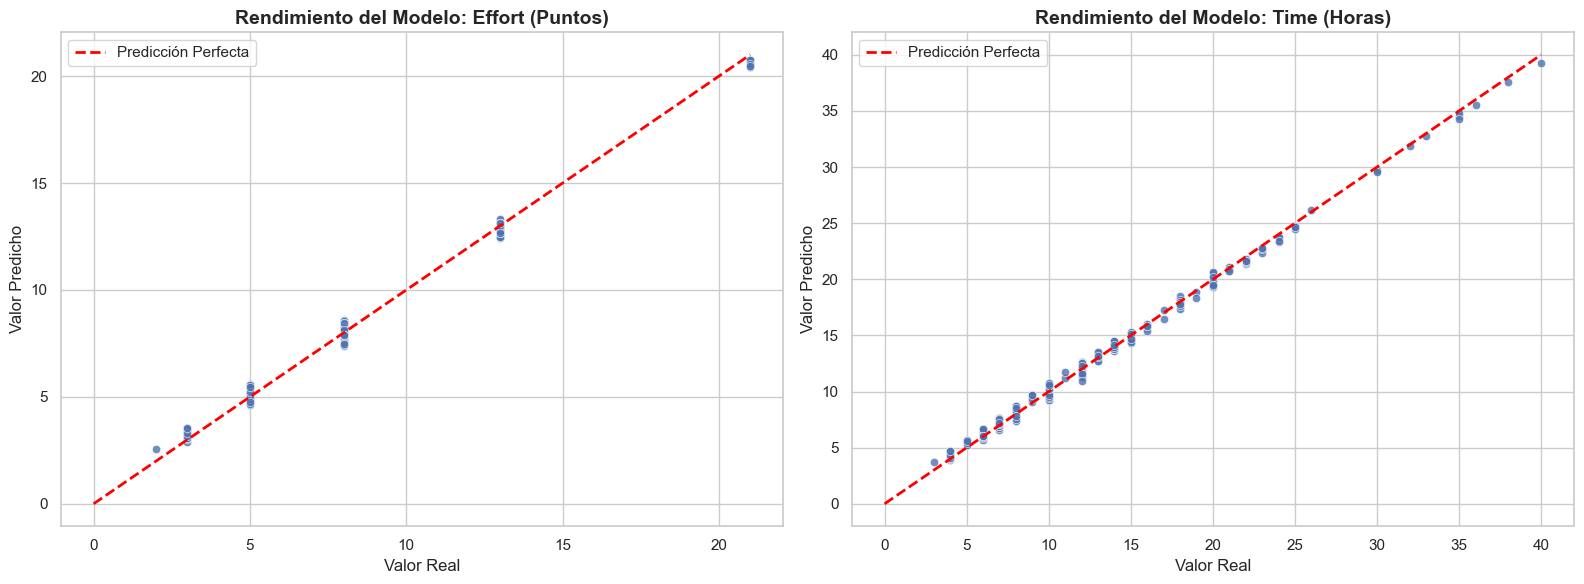

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 7. Visualización de Resultados del Mejor Modelo ---
# Usamos el modelo 'mejorado' que ya fue entrenado con GridSearchCV
print("\n📊 Generando gráficos de rendimiento para el modelo mejorado...")

# Obtener las predicciones para todo el conjunto de datos usando el mejor modelo encontrado
best_model_improved = grid_search_improved.best_estimator_
y_pred = best_model_improved.predict(X)

# Crear un DataFrame con los resultados para facilitar el ploteo
results_df = pd.DataFrame({
    'effort_real': y['effort'],
    'effort_pred': y_pred[:, 0], # La primera columna de la predicción es 'effort'
    'time_real': y['time'],
    'time_pred': y_pred[:, 1]   # La segunda columna es 'time'
})

# --- Gráfico 1: Predicciones vs. Valores Reales ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_theme(style="whitegrid")

# Gráfico para 'effort'
sns.scatterplot(data=results_df, x='effort_real', y='effort_pred', ax=axes[0], alpha=0.8)
axes[0].set_title('Rendimiento del Modelo: Effort (Puntos)', fontsize=14, weight='bold')
axes[0].set_xlabel('Valor Real', fontsize=12)
axes[0].set_ylabel('Valor Predicho', fontsize=12)
# Añadimos la línea de 45 grados para referencia (predicción perfecta)
max_val_effort = max(results_df['effort_real'].max(), results_df['effort_pred'].max())
axes[0].plot([0, max_val_effort], [0, max_val_effort], color='red', linestyle='--', lw=2, label='Predicción Perfecta')
axes[0].legend()

# Gráfico para 'time'
sns.scatterplot(data=results_df, x='time_real', y='time_pred', ax=axes[1], alpha=0.8)
axes[1].set_title('Rendimiento del Modelo: Time (Horas)', fontsize=14, weight='bold')
axes[1].set_xlabel('Valor Real', fontsize=12)
axes[1].set_ylabel('Valor Predicho', fontsize=12)
# Añadimos la línea de 45 grados
max_val_time = max(results_df['time_real'].max(), results_df['time_pred'].max())
axes[1].plot([0, max_val_time], [0, max_val_time], color='red', linestyle='--', lw=2, label='Predicción Perfecta')
axes[1].legend()

plt.tight_layout()
plt.show()

###  Una Consideración Importante

Un rendimiento tan bueno es fantástico, pero a menudo se ve en una de estas situaciones:
1.  **El conjunto de datos es pequeño o simple**, y el modelo ha podido aprender perfectamente sus patrones (como en el DataFrame de ejemplo que usamos).
2.  **Las características tienen una relación muy fuerte y directa** con los valores a predecir.

El siguiente paso crucial sería **validar este modelo con un conjunto de datos completamente nuevo** (datos de prueba que no se usaron en ningún momento del entrenamiento o ajuste) para asegurar que su rendimiento se mantiene y no está simplemente "memorizando" los datos que ya conoce.

In [ ]:
import joblib

# 1. Acceder al mejor modelo encontrado por GridSearchCV
#    best_estimator_ contiene el Pipeline completo (preprocesador + modelo) ya entrenado.
best_model = grid_search_improved.best_estimator_

# 2. Definir el nombre del archivo
filename = 'effort_model.joblib'

# 3. Guardar el modelo en el archivo
joblib.dump(best_model, filename)

print(f"\n✅ ¡Modelo guardado exitosamente en el archivo '{filename}'!")


✅ ¡Modelo guardado exitosamente en el archivo 'effort_model.joblib'!
